In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:oracle.run2.framed",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1400], examples_per_second: 740.7885, train_label_loss: 2.8028, 


epoch: 1, [batch: 140 / 1400], examples_per_second: 12727.1671, train_label_loss: 2.6679, 


epoch: 1, [batch: 280 / 1400], examples_per_second: 12836.3723, train_label_loss: 2.6505, 


epoch: 1, [batch: 420 / 1400], examples_per_second: 12868.1505, train_label_loss: 2.3399, 


epoch: 1, [batch: 560 / 1400], examples_per_second: 12824.8187, train_label_loss: 2.3173, 


epoch: 1, [batch: 700 / 1400], examples_per_second: 12810.3289, train_label_loss: 2.0973, 


epoch: 1, [batch: 840 / 1400], examples_per_second: 12898.3973, train_label_loss: 2.0246, 


epoch: 1, [batch: 980 / 1400], examples_per_second: 12772.3013, train_label_loss: 2.0467, 


epoch: 1, [batch: 1120 / 1400], examples_per_second: 12847.3560, train_label_loss: 1.7483, 


epoch: 1, [batch: 1260 / 1400], examples_per_second: 12797.0222, train_label_loss: 1.6216, 


epoch: 1, source_val_acc_label: 0.5417, source_val_label_loss: 1.5608, target_val_acc_label: 0.5417, target_val_label_loss: 1.5608, 


New best
epoch: 2, [batch: 1 / 1400], examples_per_second: 61.6441, train_label_loss: 1.4618, 


epoch: 2, [batch: 140 / 1400], examples_per_second: 12826.7985, train_label_loss: 1.3508, 


epoch: 2, [batch: 280 / 1400], examples_per_second: 12793.2539, train_label_loss: 1.3269, 


epoch: 2, [batch: 420 / 1400], examples_per_second: 12846.4360, train_label_loss: 1.1724, 


epoch: 2, [batch: 560 / 1400], examples_per_second: 12768.9727, train_label_loss: 1.2889, 


epoch: 2, [batch: 700 / 1400], examples_per_second: 12764.7462, train_label_loss: 0.9930, 


epoch: 2, [batch: 840 / 1400], examples_per_second: 12865.4302, train_label_loss: 1.0746, 


epoch: 2, [batch: 980 / 1400], examples_per_second: 12733.9982, train_label_loss: 0.9321, 


epoch: 2, [batch: 1120 / 1400], examples_per_second: 12687.5189, train_label_loss: 0.8931, 


epoch: 2, [batch: 1260 / 1400], examples_per_second: 13710.2862, train_label_loss: 0.6550, 


epoch: 2, source_val_acc_label: 0.8443, source_val_label_loss: 0.6819, target_val_acc_label: 0.8443, target_val_label_loss: 0.6819, 


New best
epoch: 3, [batch: 1 / 1400], examples_per_second: 70.6749, train_label_loss: 0.6952, 


epoch: 3, [batch: 140 / 1400], examples_per_second: 12552.0849, train_label_loss: 0.6959, 


epoch: 3, [batch: 280 / 1400], examples_per_second: 12719.2371, train_label_loss: 0.6651, 


epoch: 3, [batch: 420 / 1400], examples_per_second: 12995.5040, train_label_loss: 0.7667, 


epoch: 3, [batch: 560 / 1400], examples_per_second: 12778.9158, train_label_loss: 0.5426, 


epoch: 3, [batch: 700 / 1400], examples_per_second: 12682.9630, train_label_loss: 0.6817, 


epoch: 3, [batch: 840 / 1400], examples_per_second: 12681.3538, train_label_loss: 0.5184, 


epoch: 3, [batch: 980 / 1400], examples_per_second: 12850.2049, train_label_loss: 0.5242, 


epoch: 3, [batch: 1120 / 1400], examples_per_second: 12834.6385, train_label_loss: 0.4795, 


epoch: 3, [batch: 1260 / 1400], examples_per_second: 12764.3322, train_label_loss: 0.4744, 


epoch: 3, source_val_acc_label: 0.9005, source_val_label_loss: 0.4005, target_val_acc_label: 0.9005, target_val_label_loss: 0.4005, 


New best
epoch: 4, [batch: 1 / 1400], examples_per_second: 70.3657, train_label_loss: 0.3014, 


epoch: 4, [batch: 140 / 1400], examples_per_second: 12727.2061, train_label_loss: 0.4541, 


epoch: 4, [batch: 280 / 1400], examples_per_second: 12624.6332, train_label_loss: 0.5059, 


epoch: 4, [batch: 420 / 1400], examples_per_second: 12782.7842, train_label_loss: 0.4858, 


epoch: 4, [batch: 560 / 1400], examples_per_second: 12860.0526, train_label_loss: 0.3455, 


epoch: 4, [batch: 700 / 1400], examples_per_second: 12750.0263, train_label_loss: 0.2989, 


epoch: 4, [batch: 840 / 1400], examples_per_second: 12779.3373, train_label_loss: 0.3836, 


epoch: 4, [batch: 980 / 1400], examples_per_second: 12766.9014, train_label_loss: 0.4454, 


epoch: 4, [batch: 1120 / 1400], examples_per_second: 12809.7853, train_label_loss: 0.3105, 


epoch: 4, [batch: 1260 / 1400], examples_per_second: 12812.1217, train_label_loss: 0.3046, 


epoch: 4, source_val_acc_label: 0.9295, source_val_label_loss: 0.2749, target_val_acc_label: 0.9295, target_val_label_loss: 0.2749, 


New best
epoch: 5, [batch: 1 / 1400], examples_per_second: 71.3784, train_label_loss: 0.2087, 


epoch: 5, [batch: 140 / 1400], examples_per_second: 12815.0274, train_label_loss: 0.3186, 


epoch: 5, [batch: 280 / 1400], examples_per_second: 12920.9565, train_label_loss: 0.2642, 


epoch: 5, [batch: 420 / 1400], examples_per_second: 12821.9593, train_label_loss: 0.2286, 


epoch: 5, [batch: 560 / 1400], examples_per_second: 12962.8710, train_label_loss: 0.2934, 


epoch: 5, [batch: 700 / 1400], examples_per_second: 12967.0798, train_label_loss: 0.3208, 


epoch: 5, [batch: 840 / 1400], examples_per_second: 12896.6268, train_label_loss: 0.2950, 


epoch: 5, [batch: 980 / 1400], examples_per_second: 12982.1979, train_label_loss: 0.2577, 


epoch: 5, [batch: 1120 / 1400], examples_per_second: 12961.7577, train_label_loss: 0.3868, 


epoch: 5, [batch: 1260 / 1400], examples_per_second: 12976.6483, train_label_loss: 0.5160, 


epoch: 5, source_val_acc_label: 0.9395, source_val_label_loss: 0.2193, target_val_acc_label: 0.9395, target_val_label_loss: 0.2193, 


New best
epoch: 6, [batch: 1 / 1400], examples_per_second: 71.5231, train_label_loss: 0.2336, 


epoch: 6, [batch: 140 / 1400], examples_per_second: 12828.9441, train_label_loss: 0.2437, 


epoch: 6, [batch: 280 / 1400], examples_per_second: 12884.3482, train_label_loss: 0.2882, 


epoch: 6, [batch: 420 / 1400], examples_per_second: 12939.5994, train_label_loss: 0.3030, 


epoch: 6, [batch: 560 / 1400], examples_per_second: 12991.0230, train_label_loss: 0.3607, 


epoch: 6, [batch: 700 / 1400], examples_per_second: 13006.8812, train_label_loss: 0.2127, 


epoch: 6, [batch: 840 / 1400], examples_per_second: 12929.2514, train_label_loss: 0.1837, 


epoch: 6, [batch: 980 / 1400], examples_per_second: 12896.9853, train_label_loss: 0.2677, 


epoch: 6, [batch: 1120 / 1400], examples_per_second: 12914.3030, train_label_loss: 0.2755, 


epoch: 6, [batch: 1260 / 1400], examples_per_second: 12813.9609, train_label_loss: 0.1840, 


epoch: 6, source_val_acc_label: 0.9420, source_val_label_loss: 0.2209, target_val_acc_label: 0.9420, target_val_label_loss: 0.2209, 


New best
epoch: 7, [batch: 1 / 1400], examples_per_second: 71.0154, train_label_loss: 0.2085, 


epoch: 7, [batch: 140 / 1400], examples_per_second: 12855.7056, train_label_loss: 0.1145, 


epoch: 7, [batch: 280 / 1400], examples_per_second: 12914.9065, train_label_loss: 0.1425, 


epoch: 7, [batch: 420 / 1400], examples_per_second: 12814.1815, train_label_loss: 0.2739, 


epoch: 7, [batch: 560 / 1400], examples_per_second: 12905.9009, train_label_loss: 0.2859, 


epoch: 7, [batch: 700 / 1400], examples_per_second: 12928.2529, train_label_loss: 0.1210, 


epoch: 7, [batch: 840 / 1400], examples_per_second: 12956.1072, train_label_loss: 0.1758, 


epoch: 7, [batch: 980 / 1400], examples_per_second: 12938.0024, train_label_loss: 0.3157, 


epoch: 7, [batch: 1120 / 1400], examples_per_second: 12903.0052, train_label_loss: 0.1965, 


epoch: 7, [batch: 1260 / 1400], examples_per_second: 12893.3150, train_label_loss: 0.1797, 


epoch: 7, source_val_acc_label: 0.9447, source_val_label_loss: 0.1817, target_val_acc_label: 0.9447, target_val_label_loss: 0.1817, 


New best
epoch: 8, [batch: 1 / 1400], examples_per_second: 71.2336, train_label_loss: 0.1202, 


epoch: 8, [batch: 140 / 1400], examples_per_second: 12874.6155, train_label_loss: 0.2052, 


epoch: 8, [batch: 280 / 1400], examples_per_second: 12937.1718, train_label_loss: 0.1904, 


epoch: 8, [batch: 420 / 1400], examples_per_second: 12931.4892, train_label_loss: 0.2016, 


epoch: 8, [batch: 560 / 1400], examples_per_second: 12941.2637, train_label_loss: 0.1155, 


epoch: 8, [batch: 700 / 1400], examples_per_second: 12914.5004, train_label_loss: 0.1712, 


epoch: 8, [batch: 840 / 1400], examples_per_second: 12927.8993, train_label_loss: 0.2206, 


epoch: 8, [batch: 980 / 1400], examples_per_second: 12945.1129, train_label_loss: 0.1772, 


epoch: 8, [batch: 1120 / 1400], examples_per_second: 12902.6751, train_label_loss: 0.1033, 


epoch: 8, [batch: 1260 / 1400], examples_per_second: 12957.6439, train_label_loss: 0.1784, 


epoch: 8, source_val_acc_label: 0.9541, source_val_label_loss: 0.2902, target_val_acc_label: 0.9541, target_val_label_loss: 0.2902, 


New best
epoch: 9, [batch: 1 / 1400], examples_per_second: 71.8475, train_label_loss: 0.1501, 


epoch: 9, [batch: 140 / 1400], examples_per_second: 13892.2038, train_label_loss: 0.2478, 


epoch: 9, [batch: 280 / 1400], examples_per_second: 14103.9083, train_label_loss: 0.2087, 


epoch: 9, [batch: 420 / 1400], examples_per_second: 14137.5307, train_label_loss: 0.1243, 


epoch: 9, [batch: 560 / 1400], examples_per_second: 14051.9501, train_label_loss: 0.2411, 


epoch: 9, [batch: 700 / 1400], examples_per_second: 14020.2915, train_label_loss: 0.1718, 


epoch: 9, [batch: 840 / 1400], examples_per_second: 14016.7226, train_label_loss: 0.1613, 


epoch: 9, [batch: 980 / 1400], examples_per_second: 13953.6615, train_label_loss: 0.1380, 


epoch: 9, [batch: 1120 / 1400], examples_per_second: 13957.6416, train_label_loss: 0.1592, 


epoch: 9, [batch: 1260 / 1400], examples_per_second: 12428.3771, train_label_loss: 0.1335, 


epoch: 9, source_val_acc_label: 0.9487, source_val_label_loss: 0.1644, target_val_acc_label: 0.9487, target_val_label_loss: 0.1644, 


epoch: 10, [batch: 1 / 1400], examples_per_second: 63.9446, train_label_loss: 0.1214, 


epoch: 10, [batch: 140 / 1400], examples_per_second: 11517.8353, train_label_loss: 0.0704, 


epoch: 10, [batch: 280 / 1400], examples_per_second: 11751.9507, train_label_loss: 0.0971, 


epoch: 10, [batch: 420 / 1400], examples_per_second: 11700.0171, train_label_loss: 0.1471, 


epoch: 10, [batch: 560 / 1400], examples_per_second: 11692.7402, train_label_loss: 0.1172, 


epoch: 10, [batch: 700 / 1400], examples_per_second: 11707.0077, train_label_loss: 0.0831, 


epoch: 10, [batch: 840 / 1400], examples_per_second: 11670.0612, train_label_loss: 0.0864, 


epoch: 10, [batch: 980 / 1400], examples_per_second: 11702.3215, train_label_loss: 0.1733, 


epoch: 10, [batch: 1120 / 1400], examples_per_second: 11736.5325, train_label_loss: 0.2301, 


epoch: 10, [batch: 1260 / 1400], examples_per_second: 11786.8762, train_label_loss: 0.1512, 


epoch: 10, source_val_acc_label: 0.9598, source_val_label_loss: 0.1376, target_val_acc_label: 0.9598, target_val_label_loss: 0.1376, 


New best
epoch: 11, [batch: 1 / 1400], examples_per_second: 63.1833, train_label_loss: 0.1432, 


epoch: 11, [batch: 140 / 1400], examples_per_second: 11632.9604, train_label_loss: 0.1328, 


epoch: 11, [batch: 280 / 1400], examples_per_second: 11709.0065, train_label_loss: 0.1534, 


epoch: 11, [batch: 420 / 1400], examples_per_second: 11660.2595, train_label_loss: 0.2101, 


epoch: 11, [batch: 560 / 1400], examples_per_second: 11690.5069, train_label_loss: 0.1003, 


epoch: 11, [batch: 700 / 1400], examples_per_second: 11660.9578, train_label_loss: 0.1564, 


epoch: 11, [batch: 840 / 1400], examples_per_second: 11657.4853, train_label_loss: 0.1717, 


epoch: 11, [batch: 980 / 1400], examples_per_second: 11687.6001, train_label_loss: 0.1706, 


epoch: 11, [batch: 1120 / 1400], examples_per_second: 11708.9846, train_label_loss: 0.1463, 


epoch: 11, [batch: 1260 / 1400], examples_per_second: 11684.6966, train_label_loss: 0.2577, 


epoch: 11, source_val_acc_label: 0.9516, source_val_label_loss: 0.1520, target_val_acc_label: 0.9516, target_val_label_loss: 0.1520, 


epoch: 12, [batch: 1 / 1400], examples_per_second: 65.2331, train_label_loss: 0.1883, 


epoch: 12, [batch: 140 / 1400], examples_per_second: 11669.0628, train_label_loss: 0.0902, 


epoch: 12, [batch: 280 / 1400], examples_per_second: 11694.5922, train_label_loss: 0.1145, 


epoch: 12, [batch: 420 / 1400], examples_per_second: 11765.4349, train_label_loss: 0.2124, 


epoch: 12, [batch: 560 / 1400], examples_per_second: 11711.3199, train_label_loss: 0.1663, 


epoch: 12, [batch: 700 / 1400], examples_per_second: 11683.7503, train_label_loss: 0.1838, 


epoch: 12, [batch: 840 / 1400], examples_per_second: 11704.4281, train_label_loss: 0.1144, 


epoch: 12, [batch: 980 / 1400], examples_per_second: 11698.0741, train_label_loss: 0.1323, 


epoch: 12, [batch: 1120 / 1400], examples_per_second: 11792.5703, train_label_loss: 0.0704, 


epoch: 12, [batch: 1260 / 1400], examples_per_second: 11698.7496, train_label_loss: 0.2196, 


epoch: 12, source_val_acc_label: 0.9591, source_val_label_loss: 0.1319, target_val_acc_label: 0.9591, target_val_label_loss: 0.1319, 


epoch: 13, [batch: 1 / 1400], examples_per_second: 64.6532, train_label_loss: 0.1015, 


epoch: 13, [batch: 140 / 1400], examples_per_second: 11631.7564, train_label_loss: 0.1386, 


epoch: 13, [batch: 280 / 1400], examples_per_second: 11670.8839, train_label_loss: 0.1002, 


epoch: 13, [batch: 420 / 1400], examples_per_second: 11664.5880, train_label_loss: 0.2108, 


epoch: 13, [batch: 560 / 1400], examples_per_second: 11677.8832, train_label_loss: 0.1476, 


epoch: 13, [batch: 700 / 1400], examples_per_second: 11994.3546, train_label_loss: 0.0726, 


epoch: 13, [batch: 840 / 1400], examples_per_second: 12400.9141, train_label_loss: 0.1311, 


epoch: 13, [batch: 980 / 1400], examples_per_second: 12550.6040, train_label_loss: 0.0512, 


epoch: 13, [batch: 1120 / 1400], examples_per_second: 12371.3828, train_label_loss: 0.1080, 


epoch: 13, [batch: 1260 / 1400], examples_per_second: 12509.2894, train_label_loss: 0.1627, 


epoch: 13, source_val_acc_label: 0.9540, source_val_label_loss: 0.1576, target_val_acc_label: 0.9540, target_val_label_loss: 0.1576, 


epoch: 14, [batch: 1 / 1400], examples_per_second: 69.8562, train_label_loss: 0.1286, 


epoch: 14, [batch: 140 / 1400], examples_per_second: 12264.6031, train_label_loss: 0.1145, 


epoch: 14, [batch: 280 / 1400], examples_per_second: 12564.5917, train_label_loss: 0.1182, 


epoch: 14, [batch: 420 / 1400], examples_per_second: 12422.2251, train_label_loss: 0.1182, 


epoch: 14, [batch: 560 / 1400], examples_per_second: 12595.5814, train_label_loss: 0.1365, 


epoch: 14, [batch: 700 / 1400], examples_per_second: 12668.9926, train_label_loss: 0.0589, 


epoch: 14, [batch: 840 / 1400], examples_per_second: 12412.1958, train_label_loss: 0.1218, 


epoch: 14, [batch: 980 / 1400], examples_per_second: 12534.5149, train_label_loss: 0.0914, 


epoch: 14, [batch: 1120 / 1400], examples_per_second: 12560.6337, train_label_loss: 0.1247, 


epoch: 14, [batch: 1260 / 1400], examples_per_second: 12529.3831, train_label_loss: 0.1304, 


epoch: 14, source_val_acc_label: 0.9679, source_val_label_loss: 0.1098, target_val_acc_label: 0.9679, target_val_label_loss: 0.1098, 


New best
epoch: 15, [batch: 1 / 1400], examples_per_second: 70.5032, train_label_loss: 0.1720, 


epoch: 15, [batch: 140 / 1400], examples_per_second: 12360.1657, train_label_loss: 0.1081, 


epoch: 15, [batch: 280 / 1400], examples_per_second: 12351.5344, train_label_loss: 0.0806, 


epoch: 15, [batch: 420 / 1400], examples_per_second: 12527.4201, train_label_loss: 0.1387, 


epoch: 15, [batch: 560 / 1400], examples_per_second: 12548.8711, train_label_loss: 0.1231, 


epoch: 15, [batch: 700 / 1400], examples_per_second: 12523.1141, train_label_loss: 0.1268, 


epoch: 15, [batch: 840 / 1400], examples_per_second: 12471.1318, train_label_loss: 0.0865, 


epoch: 15, [batch: 980 / 1400], examples_per_second: 12565.3983, train_label_loss: 0.1542, 


epoch: 15, [batch: 1120 / 1400], examples_per_second: 12738.6167, train_label_loss: 0.0548, 


epoch: 15, [batch: 1260 / 1400], examples_per_second: 12584.4464, train_label_loss: 0.1511, 


epoch: 15, source_val_acc_label: 0.9572, source_val_label_loss: 0.1663, target_val_acc_label: 0.9572, target_val_label_loss: 0.1663, 


epoch: 16, [batch: 1 / 1400], examples_per_second: 71.9018, train_label_loss: 0.0686, 


epoch: 16, [batch: 140 / 1400], examples_per_second: 12524.9524, train_label_loss: 0.1132, 


epoch: 16, [batch: 280 / 1400], examples_per_second: 12620.2982, train_label_loss: 0.1062, 


epoch: 16, [batch: 420 / 1400], examples_per_second: 12656.0011, train_label_loss: 0.1121, 


epoch: 16, [batch: 560 / 1400], examples_per_second: 12564.3438, train_label_loss: 0.0705, 


epoch: 16, [batch: 700 / 1400], examples_per_second: 12672.2414, train_label_loss: 0.1304, 


epoch: 16, [batch: 840 / 1400], examples_per_second: 12528.4099, train_label_loss: 0.0575, 


epoch: 16, [batch: 980 / 1400], examples_per_second: 12598.0874, train_label_loss: 0.1240, 


epoch: 16, [batch: 1120 / 1400], examples_per_second: 12537.1702, train_label_loss: 0.0913, 


epoch: 16, [batch: 1260 / 1400], examples_per_second: 12607.6707, train_label_loss: 0.1697, 


epoch: 16, source_val_acc_label: 0.9720, source_val_label_loss: 0.0950, target_val_acc_label: 0.9720, target_val_label_loss: 0.0950, 


New best
epoch: 17, [batch: 1 / 1400], examples_per_second: 69.6388, train_label_loss: 0.0587, 


epoch: 17, [batch: 140 / 1400], examples_per_second: 12499.5635, train_label_loss: 0.0666, 


epoch: 17, [batch: 280 / 1400], examples_per_second: 12543.8238, train_label_loss: 0.1050, 


epoch: 17, [batch: 420 / 1400], examples_per_second: 12502.6411, train_label_loss: 0.1341, 


epoch: 17, [batch: 560 / 1400], examples_per_second: 12526.9879, train_label_loss: 0.0359, 


epoch: 17, [batch: 700 / 1400], examples_per_second: 12590.8340, train_label_loss: 0.0723, 


epoch: 17, [batch: 840 / 1400], examples_per_second: 12369.4751, train_label_loss: 0.0568, 


epoch: 17, [batch: 980 / 1400], examples_per_second: 12259.8359, train_label_loss: 0.0403, 


epoch: 17, [batch: 1120 / 1400], examples_per_second: 12307.5666, train_label_loss: 0.0890, 


epoch: 17, [batch: 1260 / 1400], examples_per_second: 12401.4276, train_label_loss: 0.0661, 


epoch: 17, source_val_acc_label: 0.9704, source_val_label_loss: 0.0925, target_val_acc_label: 0.9704, target_val_label_loss: 0.0925, 


epoch: 18, [batch: 1 / 1400], examples_per_second: 70.6790, train_label_loss: 0.0915, 


epoch: 18, [batch: 140 / 1400], examples_per_second: 12479.6783, train_label_loss: 0.1151, 


epoch: 18, [batch: 280 / 1400], examples_per_second: 12513.6046, train_label_loss: 0.0869, 


epoch: 18, [batch: 420 / 1400], examples_per_second: 12382.4354, train_label_loss: 0.0723, 


epoch: 18, [batch: 560 / 1400], examples_per_second: 12553.9119, train_label_loss: 0.1408, 


epoch: 18, [batch: 700 / 1400], examples_per_second: 12662.1479, train_label_loss: 0.0477, 


epoch: 18, [batch: 840 / 1400], examples_per_second: 12471.1091, train_label_loss: 0.0950, 


epoch: 18, [batch: 980 / 1400], examples_per_second: 12571.2555, train_label_loss: 0.0788, 


epoch: 18, [batch: 1120 / 1400], examples_per_second: 12496.2804, train_label_loss: 0.0855, 


epoch: 18, [batch: 1260 / 1400], examples_per_second: 12562.1578, train_label_loss: 0.1379, 


epoch: 18, source_val_acc_label: 0.9618, source_val_label_loss: 0.1766, target_val_acc_label: 0.9618, target_val_label_loss: 0.1766, 


epoch: 19, [batch: 1 / 1400], examples_per_second: 71.7224, train_label_loss: 0.0904, 


epoch: 19, [batch: 140 / 1400], examples_per_second: 12276.8889, train_label_loss: 0.0836, 


epoch: 19, [batch: 280 / 1400], examples_per_second: 12354.5432, train_label_loss: 0.0541, 


epoch: 19, [batch: 420 / 1400], examples_per_second: 12370.2792, train_label_loss: 0.0729, 


epoch: 19, [batch: 560 / 1400], examples_per_second: 12391.4339, train_label_loss: 0.1126, 


epoch: 19, [batch: 700 / 1400], examples_per_second: 12401.4440, train_label_loss: 0.0901, 


epoch: 19, [batch: 840 / 1400], examples_per_second: 12321.5326, train_label_loss: 0.0565, 


epoch: 19, [batch: 980 / 1400], examples_per_second: 12499.7801, train_label_loss: 0.0652, 


epoch: 19, [batch: 1120 / 1400], examples_per_second: 12536.4049, train_label_loss: 0.0612, 


epoch: 19, [batch: 1260 / 1400], examples_per_second: 12593.5237, train_label_loss: 0.0657, 


epoch: 19, source_val_acc_label: 0.9704, source_val_label_loss: 0.0953, target_val_acc_label: 0.9704, target_val_label_loss: 0.0953, 


epoch: 20, [batch: 1 / 1400], examples_per_second: 71.1309, train_label_loss: 0.0540, 


epoch: 20, [batch: 140 / 1400], examples_per_second: 12539.1055, train_label_loss: 0.0688, 


epoch: 20, [batch: 280 / 1400], examples_per_second: 12507.2203, train_label_loss: 0.0481, 


epoch: 20, [batch: 420 / 1400], examples_per_second: 12589.9165, train_label_loss: 0.4443, 


epoch: 20, [batch: 560 / 1400], examples_per_second: 12397.1035, train_label_loss: 0.0742, 


epoch: 20, [batch: 700 / 1400], examples_per_second: 12362.4154, train_label_loss: 0.1139, 


epoch: 20, [batch: 840 / 1400], examples_per_second: 12473.0027, train_label_loss: 0.1441, 


epoch: 20, [batch: 980 / 1400], examples_per_second: 12464.9561, train_label_loss: 0.1427, 


epoch: 20, [batch: 1120 / 1400], examples_per_second: 12049.8983, train_label_loss: 0.1087, 


epoch: 20, [batch: 1260 / 1400], examples_per_second: 12452.8066, train_label_loss: 0.0534, 


epoch: 20, source_val_acc_label: 0.9671, source_val_label_loss: 0.1061, target_val_acc_label: 0.9671, target_val_label_loss: 0.1061, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

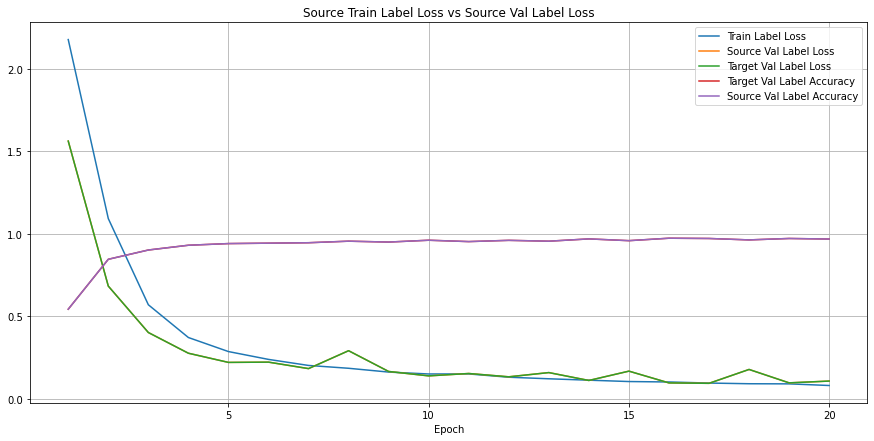

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

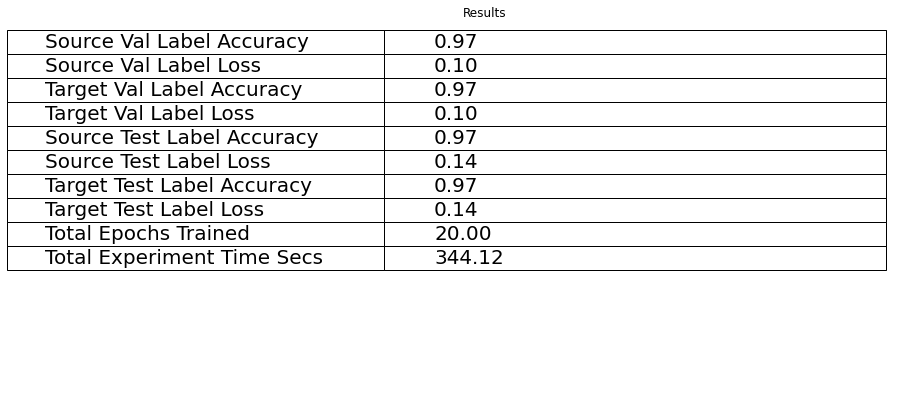

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

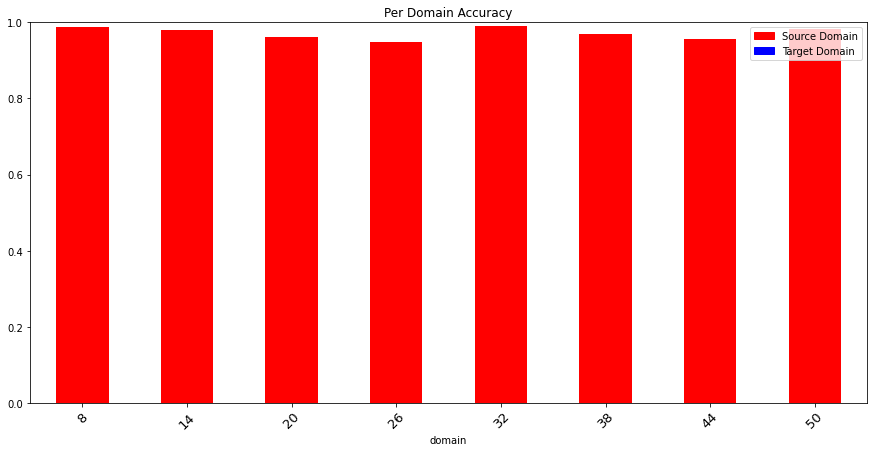

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.969375 Target Test Label Accuracy: 0.969375
Source Val Label Accuracy: 0.97203125 Target Val Label Accuracy: 0.97203125


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:oracle.run2.framed", "parameters": {"experiment_name": "cnn_2:oracle.run2.framed", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_ch